In [7]:
import tensorflow as tf

### Configuration
create_dataset = True

def in_google_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the platform
if in_google_colab():
    print("Running in Google Colab")
    !git clone https://github.com/naderinho/anesthesia_anomaly_detection
    !pip install vitaldb
    directory = 'anesthesia_anomaly_detection/data/'
    create_dataset = False
else:
    print("Running locally")
    directory = 'data/'

### Datasetpath
datasetpath = 'dataset02/'
vitaldbpath = 'vitaldb_tiva/'

import numpy as np
import pandas as pd
import vitaldb as vf
import matplotlib.pyplot as plt

Running locally


In [8]:
from scipy import ndimage

def outlierfilter(data: pd.DataFrame,threshhold: float, iterations: int, min: float, max: float):
    """
    A filter function, which calculates the gradient of a given Pandas DataFram Timeseries
    and performs a binary dilation on datapoints which exceed a certain treshhold, to detect
    and remove unwanted outliers in the dataset. Additionally all values exceeding a given
    min/max value are replaced with np.nan and linearly interpolated with the Pandas interpolate
    method.

    Args:
        data (pd.DataFrame): Timeseries Data
        threshhold (float): Gradient thresshold
        iterations (int): number of iterations of the binary dilation
        min (float): maximum expected value
        max (float): minimum expected value

    Returns:
        pd.DataFrame: _description_
    """
    gradient = np.diff(data,n=1, axis=0, append=0)
    gradientfilter = ndimage.binary_dilation(np.abs(gradient) > threshhold, iterations=iterations)

    # Apply Filter
    data[gradientfilter] = np.nan

    data[data <= min] = np.nan
    data[data > max] = np.nan

    data = data.interpolate(method = 'linear')
    data = data.bfill()
    return data

### Custom Normalization Functions

def NormStandard(dataset: np.array):
    mean = np.nanmean(dataset)
    std = np.nanstd(dataset)
    return (dataset - mean) / std

def NormMinMax(dataset: np.array):
    min = np.min(dataset)
    max = np.max(dataset)
    return (dataset - min) / (max - min)

def NormCustomBIS(dataset: np.array):
    return (100 - dataset) / 100

def NormNone(dataset: np.array):
    return dataset

In [9]:
from os import listdir
from sklearn.model_selection import train_test_split

class DatasetImport():
    def __init__(self, directory: str, dataset: str, vitalpath: str, interval: int = 10):
        self.directory = directory
        self.datasetpath = directory + dataset
        self.vitalpath = directory + vitalpath

        self.interval = interval

        self.train_dataset = None
        self.validation_dataset = None
        self.test_dataset = None

        self.index = pd.read_csv(self.datasetpath +'dataset.csv', index_col=0).index.to_numpy()

    def save(self, filename: str):
        np.savez_compressed(self.datasetpath+filename,
                            train = self.train_dataset,
                            validation = self.validation_dataset,
                            test = self.test_dataset,
                            timesteps = self.timesteps,
                            )

    def load(self, filename: str):
        data = np.load(self.datasetpath+filename)
        self.train_dataset = data['train']
        self.validation_dataset = data['validation']
        self.test_dataset = data['test']
        try:
            self.timesteps = data['timesteps']
        except:
            self.timesteps = []

    def split(self,data):
       train, test = train_test_split(data, test_size=0.15, random_state=42)
       train, validation = train_test_split(train, test_size=0.15, random_state=42)
       return train, validation, test

    def generateDataset(self, normalization):

        dataset, self.timesteps = self.generate(self.index, normalization)

        self.train_dataset, self.validation_dataset, self.test_dataset = self.split(dataset)
        print('Dataset succesfully generated                 ')

    def generate(self, dataset_index: list, normalization):
        batch_list = []
        timesteps = []

        for i, caseid in enumerate(dataset_index):
            filepath = self.vitalpath+str(caseid).zfill(4)+'.vital'
            data, importName = self.importFunction(filepath)
            timesteps.append(data.shape[0])
            batch_list.append(data)
            print(importName + " Fortschritt: %.1f" % (100 * (i+1) / len(dataset_index)),' % ', end='\r')

        ### Pad the dataset
        data = tf.keras.preprocessing.sequence.pad_sequences(batch_list, padding='post', dtype='float32', value=0.0)

        # Remove 0.0 padded values
        data[data == 0.0] = np.nan

        # Nomalization
        data = normalization(data)

        # restore padded values
        np.nan_to_num(data, copy=False, nan=0.0)

        return data, np.array(timesteps)

    def importFunction(self, filepath: str):
        return None, None

class infoImport(DatasetImport):
    def __init__(self, directory: str, dataset: str, vitalpath: str):
        super().__init__(directory,dataset,vitalpath)

        self.columns = ['sex','age','height','weight','bmi']

    def generate(self, dataset_index: list, normalization):

        data = pd.read_csv(self.directory+'info_vitaldb/cases.csv', index_col=0)
        data = data[self.columns].loc[dataset_index].to_numpy()

        sex = np.where(data[:, 0] == 'F', -0.5, 0.5)

        data = data[:,1:].astype(float)
        data = np.c_[sex, normalization(data)]

        return data, None

class VitalImport(DatasetImport):
    def __init__(self, directory: str, dataset: str, vitalpath: str):
        super().__init__(directory,dataset,vitalpath)

        self.tracks = []
        self.filter = [0,0,0]
        self.name = 'Vital'

    def importFunction(self, filepath: str):

        vitaldata = vf.VitalFile(ipath = filepath, track_names = self.tracks)

        data = vitaldata.to_pandas(track_names=self.tracks,interval=self.interval)
        data = data + 0.00001 # adds small value to avoid mix up with padding values
        data = outlierfilter(data, threshhold = self.filter[0] , iterations = 2, min = self.filter[1], max = self.filter[2])

        return data, self.name

In [11]:
info = infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info.load('01_info.npz')

bis = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bis.load('00_bis.npz')

In [27]:
bis.split(bis.timesteps)[2]
bis.split(bis.index)[2]

array([2248,  963, 3270, 5837, 3167, 3325, 3500, 2332, 1768, 4012, 4987,
       3930, 3564, 1826, 5680, 5319, 4027, 3379,   70, 4258,  167, 1925,
       5224, 4644])

In [58]:
test = {
2248: [100, 720], 
963: [200, 1900],
3270: [200, 2000], 
5837: [200, 2500],
3167: [100, 1200],
3325: [200, 1500],
3500: [200, 800],
2332: [250, 2400],
1768: [200, 1300],
4012: [100, 480],
4987: [300, 1750],
3930: [300, 2000],
3564: [100, 650],
1826: [150, 700],
5680: [100, 800],
5319: [200, 2600],
4027: [200, 1300],
3379: [200, 850],
70: [150, 1200],
4258: [200, 1900],
167: [100, 800],
1925: [200, 800],
5224:[100, 1400],
4644: [100, 2700],
}

In [31]:
data = pd.read_csv(directory+'info_vitaldb/cases.csv', index_col=0)

columns = ['casestart','caseend','anestart','aneend','opstart','opend']

data = data[columns].loc[bis.split(bis.index)[2]]

data['timesteps'] = bis.split(bis.timesteps)[2] * 10

In [61]:
filename

2248

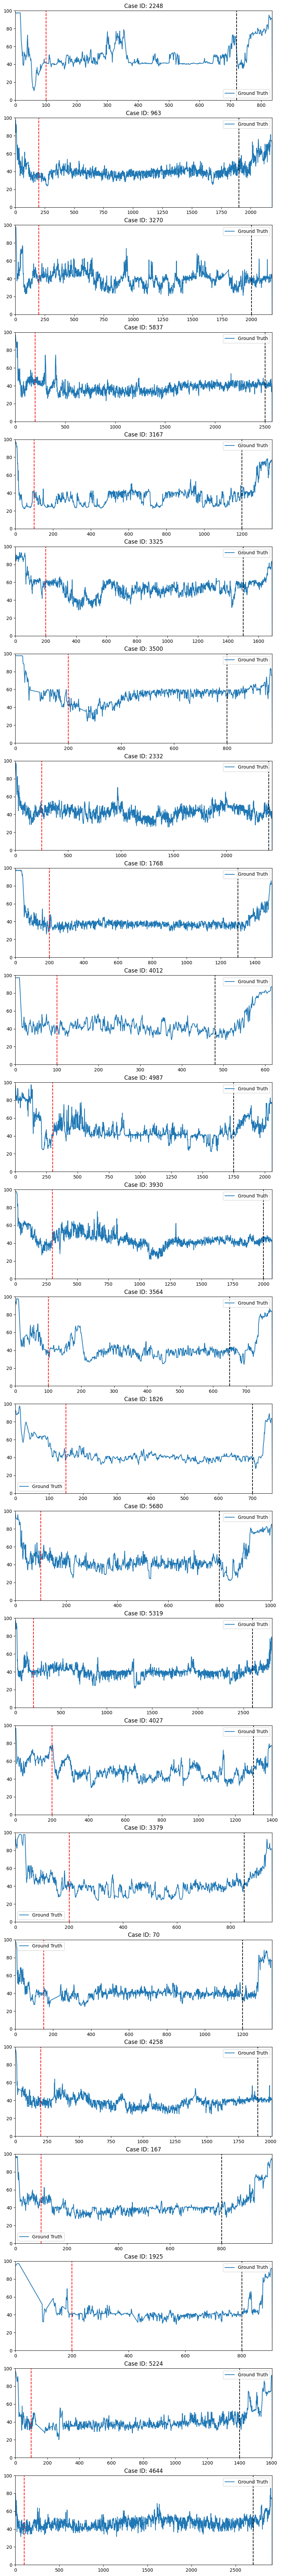

In [62]:
### Plot Test Results
train_index, val_index, test_index = bis.split(np.array(bis.index))
train_timesteps, val_timesteps, test_timesteps = bis.split(bis.timesteps)
fig, axs = plt.subplots(bis.test_dataset.shape[0], 1, figsize=(10, 100))

timings = pd.read_csv(directory+'info_vitaldb/cases.csv', index_col=0)
columns = ['casestart','caseend','anestart','aneend','opstart','opend']

for j, filename in enumerate(test_index):
    axs[j].plot(bis.test_dataset[j,:,:], label='Ground Truth')
    axs[j].legend()
    axs[j].set_title('Case ID: ' + str(filename))
    axs[j].axis([0,test_timesteps[j]-1,0,100])
    axs[j].vlines(test[filename][0], 0, 100, colors='r', linestyles='dashed')
    axs[j].vlines(test[filename][1], 0, 100, colors='k', linestyles='dashed')